In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (GridSearchCV, ParameterGrid,
                                     RandomizedSearchCV)
from sklearn.metrics import fbeta_score, make_scorer
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from tools import (COLUMNS_QUANT, COLUMNS_CAT,
                   Modelisation, datasets, SearchCV, restauration_CV, 
                   graph_2scores_CV, graph_3scores_CV, graph_param_CV, 
                   best_score_CV)

## Matplotlib : 
# Pour affichage interactif (notamment 3D) dans notebook
# %matplotlib widget

# Pour affichage interactif (notamment 3D) dans une fenêtre qt externe au notebook
# %matplotlib qt

# Pour affichage simple dans notebook
# %config InlineBackend.figure_format = 'png'

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 48)

**Définition des variables quantitatives, des variables catégorielles et des datasets :**

In [3]:
datasets_df = datasets(df)
X_quant = datasets_df['X_quant']
X_cat = datasets_df['X_cat']
X = datasets_df['X']
y = datasets_df['y']

Columns_quant :


['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro']


Columns_cat :


['display_env',
 'target_env',
 'campaignscenario',
 'campaignvertical',
 'is_interstitial',
 'device_type',
 'hour',
 'weekday']


Nombre de variables pour X_quant : 13



Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 50



Index(['display_env_app_ios', 'display_env_other', 'display_env_web',
       'target_env_2', 'campaignscenario_5', 'campaignscenario_6',
       'campaignscenario_11', 'campaignscenario_12', 'campaignscenario_13',
       'campaignscenario_17', 'campaignvertical_20.0', 'campaignvertical_23.0',
       'campaignvertical_129.0', 'campaignvertical_200002.0',
       'is_interstitial_True', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')


Nombre de variables pour X : 63


Afin de comparer nos modèles en termes de performances brutes et de temps d'exécution, il est fondamental de déterminer quelques métriques de référence. Ici, il faut surtout faire en sorte d'éviter de prédire des non-clics qui seraient en réalité des clics (ie prédire trop de 0), quitte à prédire trop de 1. Autrement dit, il faut maximiser le recall et le NPV (Negative predictive value) afin de limiter les erreurs de type II. Le F1 Score, combinaison du recall et de la précision, est également pertinent. 

# Régression logistique
## Variables quantitatives

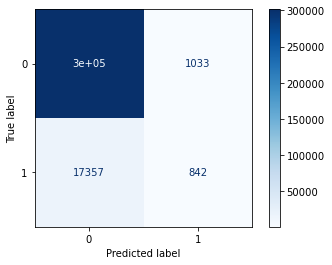

f1 : 0.0839
f3 : 0.0508
f5 : 0.0479
recall : 0.0463
negative predictive value : 0.9456
precision : 0.4491
roc_auc : 0.7406
training time : 2.227s
prediction time : 0.011s


In [4]:
m = Modelisation(X_quant, y, LogisticRegression(), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

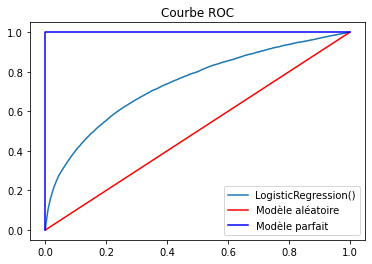

In [5]:
m.show_ROC()

In [6]:
coeff_df = pd.DataFrame(np.transpose(m.model.coef_), X_quant.columns, columns=['Coefficient'])
coeff_df

,Coefficient
contextid,-0.026814
campaignctrlast24h,0.359862
dayssincelastvisitdouble,-0.029801
ltf_nbglobaldisplay_4w,0.012018
ltf_nbpartnerdisplayssincelastclick,-0.031350
ltf_nbpartnerdisplay_90d,-0.011750
ltf_nbpartnerclick_90d,0.032189
ltf_nbpartnersales_90d,-0.008756
nbdayssincelastclick,-0.107369
nbdisplay_1hour,-0.216836


**Problème :** pas de scaling dans la cellule suivante

In [7]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

X_quant_scaled = datasets_df['X_quant_scaled']
X_ = add_constant(X_quant_scaled)
print(Logit(y, X_).fit().summary())

Optimization terminated successfully.
         Current function value: 0.197291
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:     is_display_clicked   No. Observations:              1603554
Model:                          Logit   Df Residuals:                  1603540
Method:                           MLE   Df Model:                           13
Date:                Fri, 12 Mar 2021   Pseudo R-squ.:                 0.09816
Time:                        07:33:00   Log-Likelihood:            -3.1637e+05
converged:                       True   LL-Null:                   -3.5080e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0392      0.004   -760.154      0.000      -3.047      -3.031
x1            -0.0256      0.

Avec LASSO (+ univariate mais variable déjà exclue par Lasso): 

In [8]:
X1 = df[['contextid',
         'zonecostineuro',
         'campaignctrlast24h',
         'ltf_nbpartnerclick_90d',
         'nbdisplay_1hour',
         'nbdayssincelastclick',
         'display_size',
         'nbdisplayglobalapprox_1d_sum_xdevice']]
y1 = df['is_display_clicked']

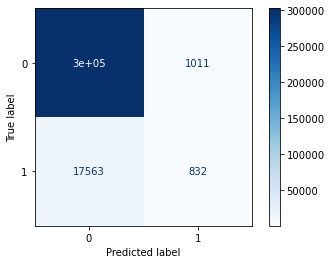

f1 : 0.0822
f3 : 0.0497
f5 : 0.0469
recall : 0.0452
negative predictive value : 0.9452
precision : 0.4514
roc_auc : 0.7398
training time : 1.571s
prediction time : 0.018s


In [9]:
m1 = Modelisation(X1, y1, LogisticRegression(), scaling=True)
m1.show_conf_matrix()
m1.show_metrics_score()

## Variables catégorielles

In [10]:
# Nombre de valeurs distinctes
from tools import COLUMNS_CAT
for column in COLUMNS_CAT:
    print(f"{column} : {len(set(df[column]))}")

display_env : 4
target_env : 2
campaignscenario : 7
campaignvertical : 34
is_interstitial : 3
device_type : 7
hour : 24
weekday : 7


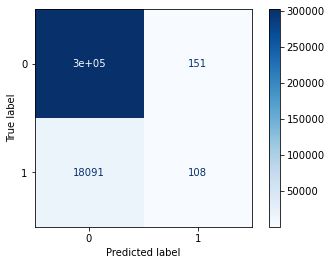

f1 : 0.0117
f3 : 0.0066
f5 : 0.0062
recall : 0.0059
negative predictive value : 0.9435
precision : 0.4170
roc_auc : 0.6887
training time : 6.62s
prediction time : 0.03s


In [11]:
m = Modelisation(X_cat, y, LogisticRegression(), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

## Variables quantitatives + catégorielles

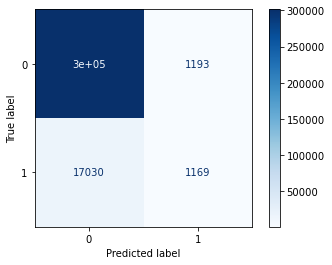

f1 : 0.1137
f3 : 0.0704
f5 : 0.0665
recall : 0.0642
negative predictive value : 0.9465
precision : 0.4949
roc_auc : 0.7575
training time : 7.885s
prediction time : 0.033s


In [12]:
m = Modelisation(X, y, LogisticRegression(), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

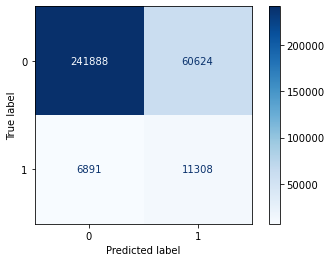

f1 : 0.2509
f3 : 0.4797
f5 : 0.5580
recall : 0.6214
negative predictive value : 0.9723
precision : 0.1572
roc_auc : 0.7781
training time : 6.578s
prediction time : 0.074s


In [13]:
m = Modelisation(X, y, LogisticRegression(class_weight='balanced'), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

Avec RFECV :

In [14]:
X2 = X[['zonecostineuro',
         'campaignctrlast24h',
         'nbdisplay_1hour',
         'nbdayssincelastclick',
         'display_size',
         'is_interstitial_True',
         'device_type_Desktop',
         'device_type_iPhone',
         'display_env_app_ios',
         'target_env_2',
         'campaignscenario_13']]

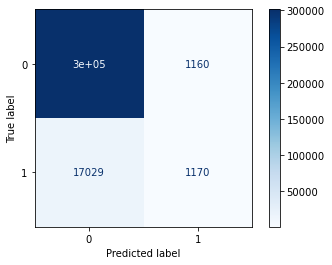

f1 : 0.1140
f3 : 0.0704
f5 : 0.0665
recall : 0.0643
negative predictive value : 0.9465
precision : 0.5021
roc_auc : 0.7543
training time : 2.435s
prediction time : 0.046s


In [15]:
m2 = Modelisation(X2, y, LogisticRegression(), scaling=True)
m2.show_conf_matrix()
m2.show_metrics_score()

## Comparaison par rapport aux valeurs de C 

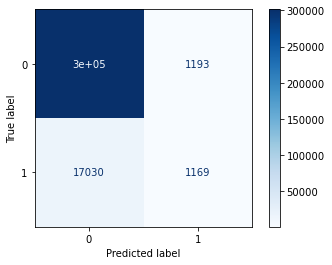

f1 : 0.1137
f3 : 0.0704
f5 : 0.0665
recall : 0.0642
negative predictive value : 0.9465
precision : 0.4949
roc_auc : 0.7575
training time : 8.176s
prediction time : 0.048s


In [16]:
m = Modelisation(X, y, LogisticRegression(C=0.2), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

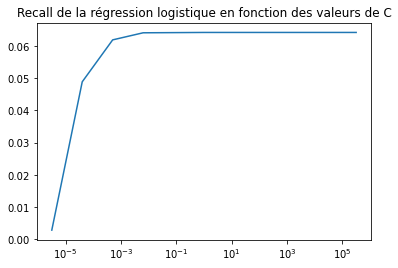

CPU times: user 20min 49s, sys: 37min 12s, total: 58min 2s
Wall time: 1min 55s


In [17]:
%%time
C, list_recall = [], []
for c in np.logspace(-5.5, 5.5, num=11): 
    m = Modelisation(X, y, LogisticRegression(C=c), scaling=True)
    C.append(c)
    list_recall.append(m.recall)
plt.plot(C, list_recall)
plt.xscale('log')
plt.title("Recall de la régression logistique en fonction des valeurs de C")
plt.show()

## Tuning des hyperparamètres avec GridSearchCV

In [18]:
model = LogisticRegression()

cv_params = {
        "C": np.logspace(-5, 4, 50),
        "class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:8}, {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16.5}] 
        }

scoring = {'recall': 'recall',
           'precision': 'precision',
           'f1': 'f1',
           'f3': make_scorer(fbeta_score, beta=3),
           'f5': make_scorer(fbeta_score, beta=5)
          }

print(len(ParameterGrid(cv_params)))

450


In [19]:
# SearchCV(model, cv_params, data_frac=1, scaling=True, scoring=scoring, random=False, n_jobs=28)

In [20]:
dico, results = restauration_CV('LR_CV_Grid_450_1')

model : LogisticRegression()
model_name : LR
type : GridSearchCV
len_grid : 450
data_frac : 1
temps : 00:32:52
n_jobs : 28
params : {'C': array([1.00000000e-05, 1.52641797e-05, 2.32995181e-05, 3.55648031e-05,
       5.42867544e-05, 8.28642773e-05, 1.26485522e-04, 1.93069773e-04,
       2.94705170e-04, 4.49843267e-04, 6.86648845e-04, 1.04811313e-03,
       1.59985872e-03, 2.44205309e-03, 3.72759372e-03, 5.68986603e-03,
       8.68511374e-03, 1.32571137e-02, 2.02358965e-02, 3.08884360e-02,
       4.71486636e-02, 7.19685673e-02, 1.09854114e-01, 1.67683294e-01,
       2.55954792e-01, 3.90693994e-01, 5.96362332e-01, 9.10298178e-01,
       1.38949549e+00, 2.12095089e+00, 3.23745754e+00, 4.94171336e+00,
       7.54312006e+00, 1.15139540e+01, 1.75751062e+01, 2.68269580e+01,
       4.09491506e+01, 6.25055193e+01, 9.54095476e+01, 1.45634848e+02,
       2.22299648e+02, 3.39322177e+02, 5.17947468e+02, 7.90604321e+02,
       1.20679264e+03, 1.84206997e+03, 2.81176870e+03, 4.29193426e+03,
       6.5

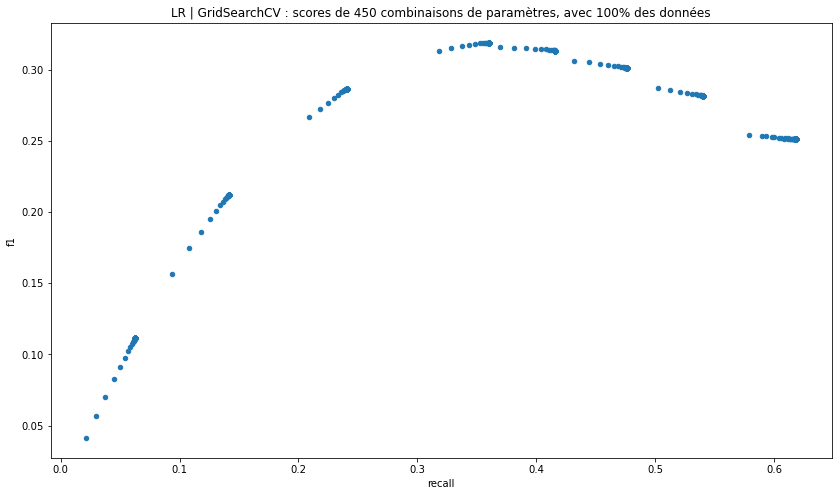

In [21]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=20)

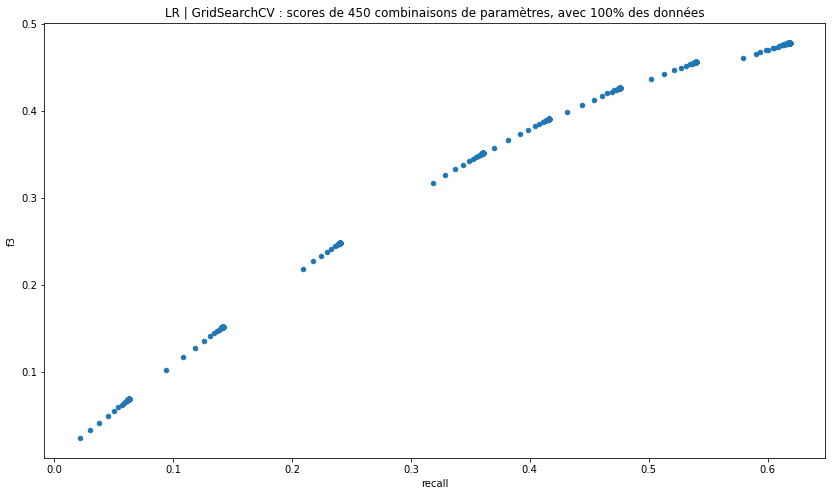

In [22]:
graph_2scores_CV(dico, results, 'recall', 'f3', s=20)

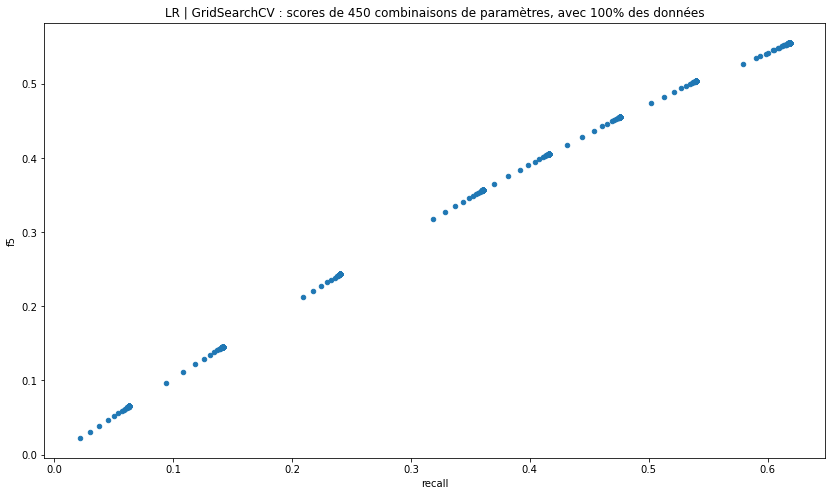

In [23]:
graph_2scores_CV(dico, results, 'recall', 'f5', s=20)

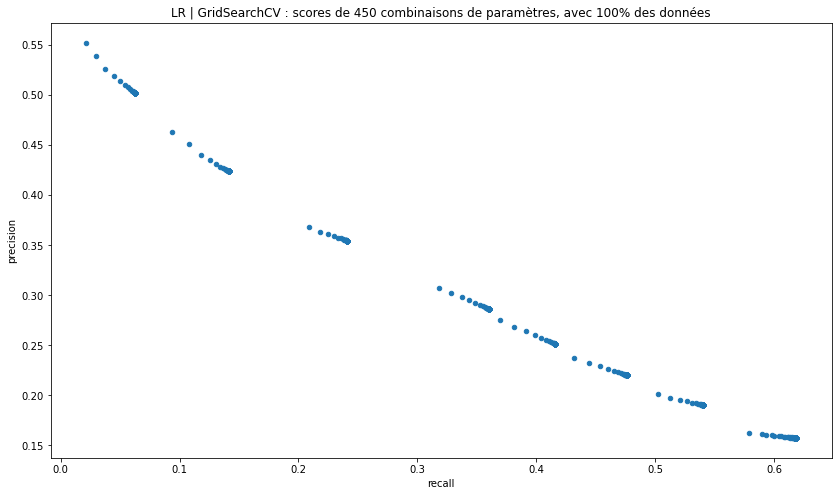

In [24]:
graph_2scores_CV(dico, results, 'recall', 'precision', s=20)

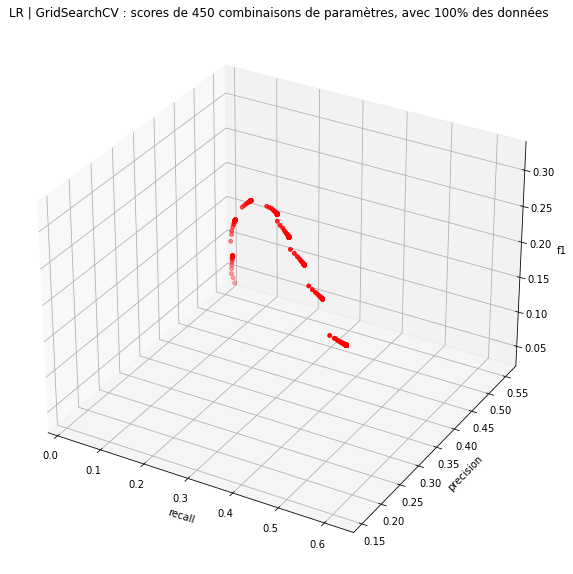

In [25]:
graph_3scores_CV(dico, results, 'recall', 'precision', 'f1', s=15)

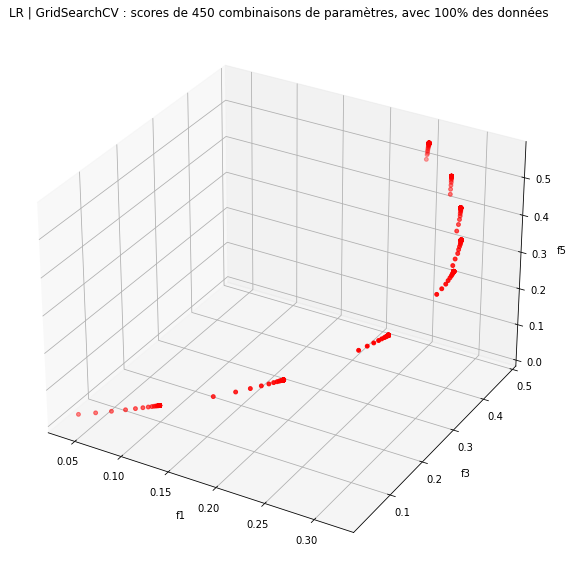

In [26]:
graph_3scores_CV(dico, results, 'f1', 'f3', 'f5', s=15)

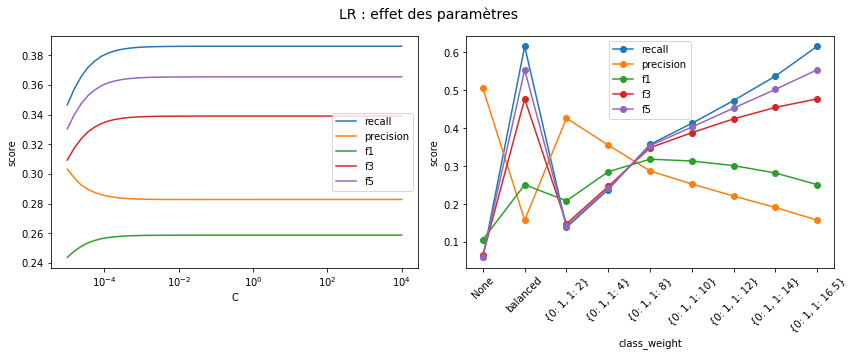

In [27]:
graph_param_CV(dico, results, xscale={'C': 'log'}, ncols=2, height=5, width=6)

In [28]:
best_params = best_score_CV(dico, results, 'f5')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,params,mean_test_recall,std_test_recall,rank_test_recall,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
199,23.036968,0.863503,1.234,0.151644,0.109854,balanced,"{'C': 0.10985411419875594, 'class_weight': 'ba...",0.618717,0.003967,1,...,416,0.251001,0.001556,312,0.478511,0.002871,1,0.556053,0.003437,1
208,23.010134,1.06159,1.362769,0.0599,0.167683,balanced,"{'C': 0.167683293681101, 'class_weight': 'bala...",0.618717,0.003967,1,...,422,0.250997,0.001555,314,0.478508,0.00287,2,0.556051,0.003436,2
226,22.958917,0.363014,1.34403,0.089874,0.390694,balanced,"{'C': 0.3906939937054621, 'class_weight': 'bal...",0.618717,0.003967,1,...,424,0.250996,0.001556,315,0.478508,0.002871,3,0.556051,0.003437,3
217,23.171917,0.887989,1.363426,0.050273,0.255955,balanced,"{'C': 0.2559547922699538, 'class_weight': 'bal...",0.618717,0.003967,1,...,425,0.250996,0.001555,316,0.478508,0.00287,4,0.556051,0.003436,4
334,23.608257,1.559965,1.342797,0.150205,62.505519,balanced,"{'C': 62.50551925273976, 'class_weight': 'bala...",0.618717,0.003967,1,...,426,0.250996,0.001557,318,0.478507,0.002872,5,0.556051,0.003437,5
424,22.660699,1.591535,1.311786,0.10152,4291.93426,balanced,"{'C': 4291.934260128778, 'class_weight': 'bala...",0.618717,0.003967,1,...,426,0.250996,0.001557,318,0.478507,0.002872,5,0.556051,0.003437,5
253,24.941653,0.865972,1.39735,0.044289,1.389495,balanced,"{'C': 1.3894954943731388, 'class_weight': 'bal...",0.618717,0.003967,1,...,426,0.250996,0.001557,318,0.478507,0.002872,5,0.556051,0.003437,5
262,24.595508,0.30506,1.259893,0.059994,2.120951,balanced,"{'C': 2.1209508879201926, 'class_weight': 'bal...",0.618717,0.003967,1,...,426,0.250996,0.001557,318,0.478507,0.002872,5,0.556051,0.003437,5
271,25.185912,1.339699,1.332723,0.11813,3.237458,balanced,"{'C': 3.2374575428176464, 'class_weight': 'bal...",0.618717,0.003967,1,...,426,0.250996,0.001557,318,0.478507,0.002872,5,0.556051,0.003437,5
280,23.774638,2.16152,1.344956,0.069472,4.941713,balanced,"{'C': 4.941713361323838, 'class_weight': 'bala...",0.618717,0.003967,1,...,426,0.250996,0.001557,318,0.478507,0.002872,5,0.556051,0.003437,5


{'C': 0.10985411419875594, 'class_weight': 'balanced'}

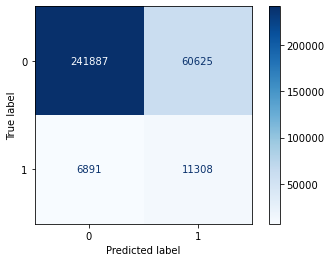

f1 : 0.2509
f3 : 0.4797
f5 : 0.5580
recall : 0.6214
negative predictive value : 0.9723
precision : 0.1572
roc_auc : 0.7781
training time : 6.467s
prediction time : 0.028s


In [29]:
m = Modelisation(X, y, LogisticRegression(**best_params), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

## Régression logistique avec sur-échantillonnage

**/!\ : Seule la base de training est sur-échantillonnée.**

In [30]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=0.05)
df.shape

(80525, 48)

In [31]:
datasets_df = datasets(df, verbose=False)
X = datasets_df['X']
y = datasets_df['y']

In [32]:
categorical_features = list(range(len(COLUMNS_QUANT), len(X.columns)))
print(categorical_features)

over = SMOTENC(categorical_features=categorical_features, 
              sampling_strategy=1, 
              k_neighbors=5,
              random_state=1234)

pipeline = Pipeline_imb([
            ('over', over),
            ('classifier', LogisticRegression())
            ])

[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]


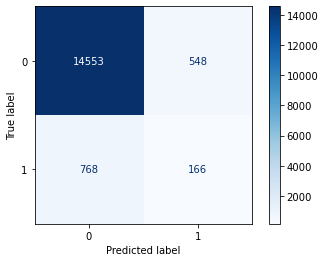

f1 : 0.2015
f3 : 0.1820
f5 : 0.1794
recall : 0.1777
negative predictive value : 0.9499
precision : 0.2325
roc_auc : 0.6855
training time : 52.483s
prediction time : 0.008s


In [33]:
m = Modelisation(X, y, pipeline, scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

In [34]:
over = RandomOverSampler(sampling_strategy=1, random_state=1234)

pipeline = Pipeline_imb([
            ('over', over),
            ('classifier', LogisticRegression())
            ])

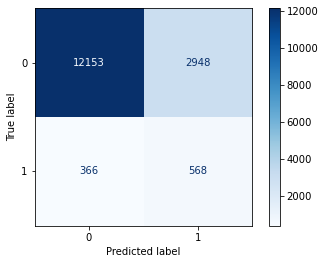

f1 : 0.2553
f3 : 0.4764
f5 : 0.5497
recall : 0.6081
negative predictive value : 0.9708
precision : 0.1615
roc_auc : 0.7674
training time : 1.0
prediction time : 0.005s


In [35]:
m = Modelisation(X, y, pipeline, scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

### GridSearchCV avec RandomOverSampler

In [36]:
over = RandomOverSampler(random_state=1234)

pipeline = Pipeline_imb([
            ('over', over),
            ('model', LogisticRegression())
            ])

cv_params = {
        "over__sampling_strategy": [0.1, 0.2, 0.4, 0.6, 0.8, 1],
        "model__C": np.logspace(-5, 4, 50),
        "model__class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:8}, {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16.5}] 
        }

print(len(ParameterGrid(cv_params)))

2700


In [37]:
# SearchCV(pipeline, cv_params, data_frac=1, scaling=True, random=False, scoring=scoring, n_jobs=28)

In [38]:
dico, results = restauration_CV('RandomOver_LR_CV_Grid_2700_1')

model : Pipeline(steps=[('over', RandomOverSampler(random_state=1234)),
                ('model', LogisticRegression())])
model_name : RandomOver_LR
type : GridSearchCV
len_grid : 2700
data_frac : 1
temps : 05:49:42
n_jobs : 28
params : {'over__sampling_strategy': [0.1, 0.2, 0.4, 0.6, 0.8, 1], 'model__C': array([1.00000000e-05, 1.52641797e-05, 2.32995181e-05, 3.55648031e-05,
       5.42867544e-05, 8.28642773e-05, 1.26485522e-04, 1.93069773e-04,
       2.94705170e-04, 4.49843267e-04, 6.86648845e-04, 1.04811313e-03,
       1.59985872e-03, 2.44205309e-03, 3.72759372e-03, 5.68986603e-03,
       8.68511374e-03, 1.32571137e-02, 2.02358965e-02, 3.08884360e-02,
       4.71486636e-02, 7.19685673e-02, 1.09854114e-01, 1.67683294e-01,
       2.55954792e-01, 3.90693994e-01, 5.96362332e-01, 9.10298178e-01,
       1.38949549e+00, 2.12095089e+00, 3.23745754e+00, 4.94171336e+00,
       7.54312006e+00, 1.15139540e+01, 1.75751062e+01, 2.68269580e+01,
       4.09491506e+01, 6.25055193e+01, 9.54095476e+01,

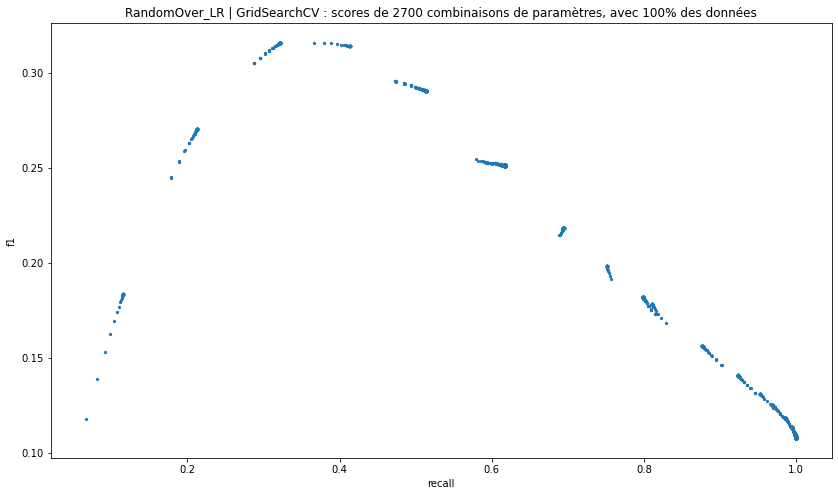

In [39]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=5)

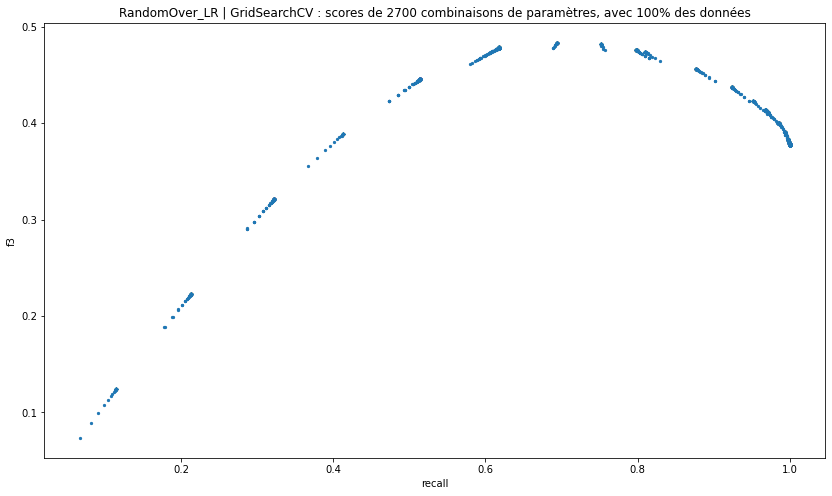

In [40]:
graph_2scores_CV(dico, results, 'recall', 'f3', s=5)

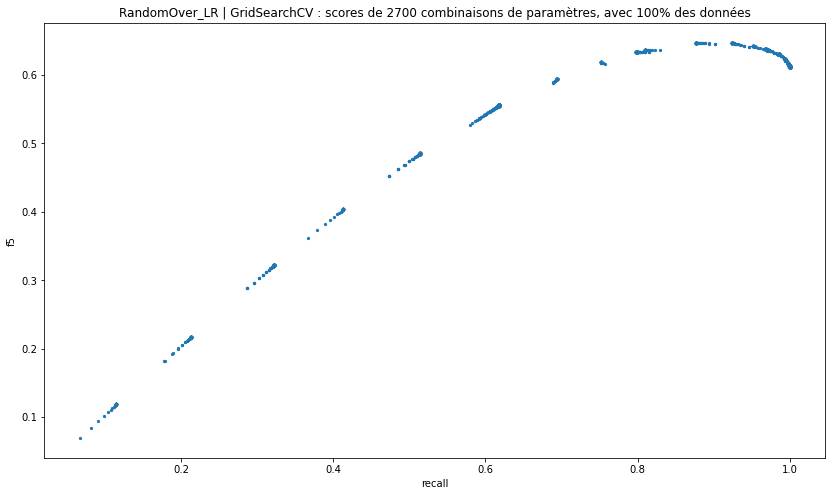

In [41]:
graph_2scores_CV(dico, results, 'recall', 'f5', s=5)

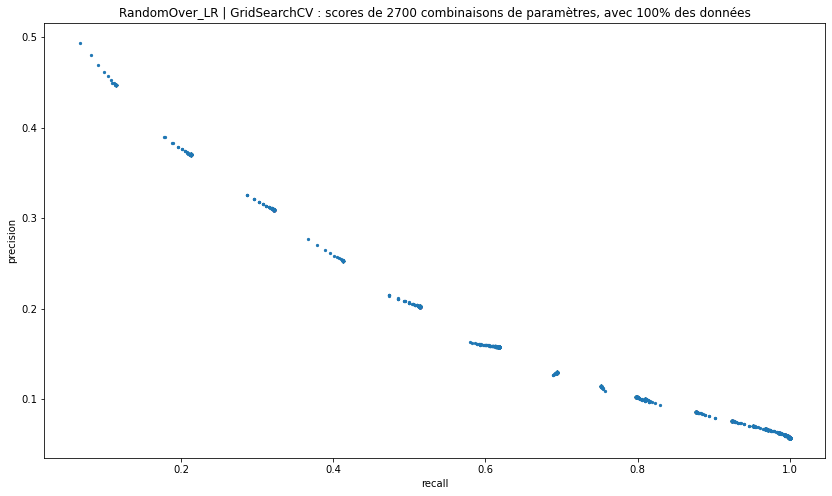

In [42]:
graph_2scores_CV(dico, results, 'recall', 'precision', s=5)

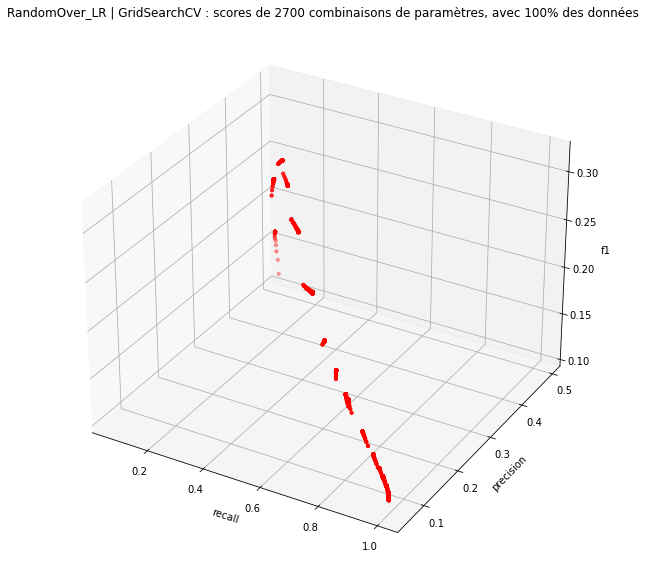

In [43]:
graph_3scores_CV(dico, results, 'recall', 'precision', 'f1', s=10)

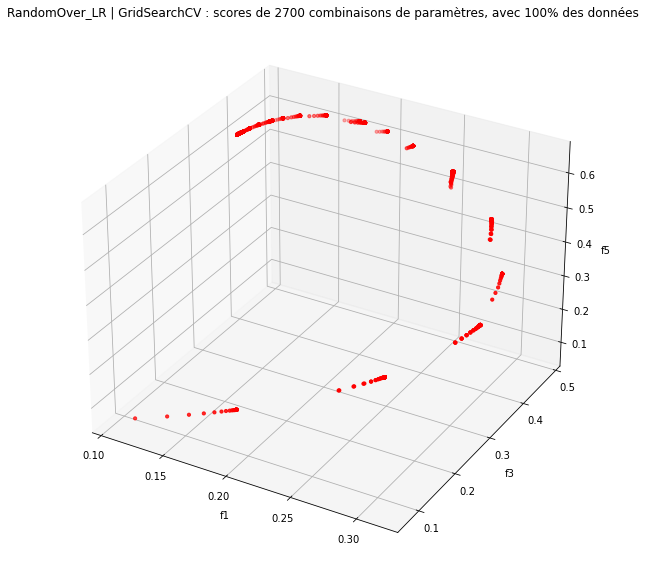

In [44]:
graph_3scores_CV(dico, results, 'f1', 'f3', 'f5', s=10)

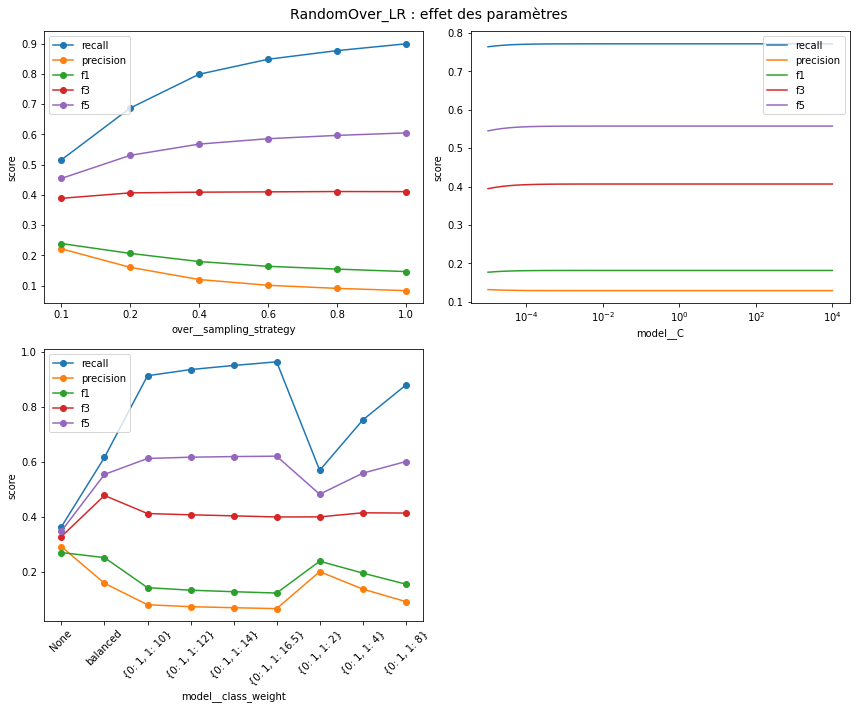

In [45]:
graph_param_CV(dico, results, xscale={'model__C': 'log'}, ncols=2, height=5, width=6)

In [46]:
best_params = best_score_CV(dico, results, 'f5')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__class_weight,param_over__sampling_strategy,params,mean_test_recall,std_test_recall,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
1219,36.411139,9.074826,1.401264,0.34165,0.109854,"{0: 1, 1: 10}",0.2,"{'model__C': 0.10985411419875594, 'model__clas...",0.876604,0.001955,...,1363,0.15633,0.000144,1359,0.456213,0.000571,788,0.64722,0.001077,1
1165,32.37787,12.088137,1.402449,0.267779,0.071969,"{0: 1, 1: 10}",0.2,"{'model__C': 0.07196856730011521, 'model__clas...",0.876604,0.001955,...,1365,0.15633,0.000143,1361,0.456213,0.000571,789,0.64722,0.001077,2
1111,38.972729,6.991927,1.599074,0.463252,0.047149,"{0: 1, 1: 10}",0.2,"{'model__C': 0.04714866363457394, 'model__clas...",0.876604,0.001955,...,1368,0.156329,0.000144,1365,0.456211,0.000573,815,0.647218,0.001078,3
1597,36.131469,7.922281,1.307247,0.394126,2.120951,"{0: 1, 1: 10}",0.2,"{'model__C': 2.1209508879201926, 'model__class...",0.876593,0.001953,...,1339,0.156332,0.000145,1336,0.456213,0.000573,790,0.647216,0.001078,4
1057,38.729741,8.623084,1.445909,0.408473,0.030888,"{0: 1, 1: 10}",0.2,"{'model__C': 0.030888435964774818, 'model__cla...",0.876604,0.001955,...,1369,0.156327,0.000143,1366,0.456208,0.00057,818,0.647216,0.001077,5
1543,41.829755,4.071962,1.612118,0.210697,1.389495,"{0: 1, 1: 10}",0.2,"{'model__C': 1.3894954943731388, 'model__class...",0.876593,0.001953,...,1340,0.156331,0.000145,1337,0.456213,0.000573,791,0.647215,0.001077,6
1651,38.656197,3.710017,1.526256,0.276474,3.237458,"{0: 1, 1: 10}",0.2,"{'model__C': 3.2374575428176464, 'model__class...",0.876593,0.001953,...,1340,0.156331,0.000145,1337,0.456213,0.000573,791,0.647215,0.001077,6
1705,31.259885,7.199315,1.488844,0.189499,4.941713,"{0: 1, 1: 10}",0.2,"{'model__C': 4.941713361323838, 'model__class_...",0.876593,0.001953,...,1340,0.156331,0.000145,1337,0.456213,0.000573,791,0.647215,0.001077,6
2407,39.509309,7.398283,1.483061,0.368536,1206.792641,"{0: 1, 1: 10}",0.2,"{'model__C': 1206.7926406393315, 'model__class...",0.876593,0.001953,...,1343,0.156331,0.000145,1340,0.456212,0.000573,794,0.647215,0.001077,9
2461,27.946795,5.537085,1.2308,0.127357,1842.069969,"{0: 1, 1: 10}",0.2,"{'model__C': 1842.0699693267163, 'model__class...",0.876593,0.001953,...,1343,0.156331,0.000145,1340,0.456212,0.000573,794,0.647215,0.001077,9


{'model__C': 0.10985411419875594,
 'model__class_weight': {0: 1, 1: 10},
 'over__sampling_strategy': 0.2}

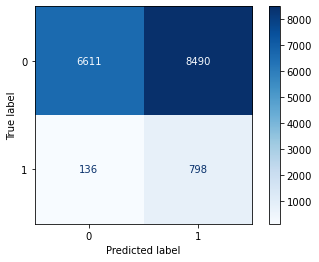

f1 : 0.1561
f3 : 0.4510
f5 : 0.6357
recall : 0.8544
negative predictive value : 0.9798
precision : 0.0859
roc_auc : 0.7693
training time : 0.648s
prediction time : 0.006s


In [47]:
m = Modelisation(X, y, pipeline.set_params(**best_params), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

In [48]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:04:50
